## PART 1: DATA CLEANING

In [57]:
!pip install folium==0.11.0 --quiet
!pip install seaborn==0.10.0 --quiet

In [63]:
import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium
import numpy as np

# to stop SettingWithCopyWarning
pd.options.mode.chained_assignment = None

### Read in list of LGA names and codes
There are thousands of rows because each LGA is repeated many times. Need to extract just the unique LGA codes and names

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
print("Shape: ", df_lga.shape)
df_lga.head()

Shape:  (85014, 6)


,MB_CODE_2016,LGA_CODE_2019,LGA_NAME_2019,STATE_CODE_2016,STATE_NAME_2016,AREA_ALBERS_SQKM
0,20000009499,29499,No usual address (Vic.),2,Victoria,0.0000
1,20000010000,20110,Alpine (S),2,Victoria,0.0127
2,20000021000,20110,Alpine (S),2,Victoria,0.0127
3,20000022000,20110,Alpine (S),2,Victoria,0.0105
4,20000023000,20110,Alpine (S),2,Victoria,0.0105


In [8]:
df_lga = df_lga[['LGA_CODE_2019', 'LGA_NAME_2019']]
df_lga.head()

,LGA_CODE_2019,LGA_NAME_2019
0,29499,No usual address (Vic.)
1,20110,Alpine (S)
2,20110,Alpine (S)
3,20110,Alpine (S)
4,20110,Alpine (S)


In [9]:
unique_lga_codes = df_lga['LGA_CODE_2019'].unique()
unique_lga_names = df_lga['LGA_NAME_2019'].unique()
df_lga_unique = pd.DataFrame({'lga_code':unique_lga_codes, 'lga_name':unique_lga_names})

In [10]:
print("Shape: ", df_lga_unique.shape)
df_lga_unique.head()

Shape:  (82, 2)


,lga_code,lga_name
0,29499,No usual address (Vic.)
1,20110,Alpine (S)
2,20260,Ararat (RC)
3,25490,Moyne (S)
4,20570,Ballarat (C)


### Read in GCP data and add the LGA names to it
Read in the Excel file, then remove the 'LGA' prefix from each LGA code in the GCP data

In [11]:
body = client_043a2ac56bbf4fe69b130a5ba4e5b0a2.get_object(Bucket='course9capstone-donotdelete-pr-qqz1u6olup7n1i',Key='gcp_selected.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_gcp = pd.read_excel(body)

In [12]:
print('Shape: ', df_gcp.shape)
df_gcp.head()

Shape:  (82, 16)


,LGA_CODE_2016,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total
0,LGA20110,6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603
1,LGA20260,5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470
2,LGA20570,52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114
3,LGA20660,62644,2033,3942,4152,4290,3115,2548,1504,1753,875,54.9,3704,2443,11312,5358
4,LGA20740,16912,1192,1257,934,698,367,295,154,156,98,42.4,299,389,1556,1547


In [13]:
df_gcp['LGA_CODE_2016'].replace('LGA', '', inplace = True, regex = True)

In [14]:
df_gcp.head()

,LGA_CODE_2016,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total
0,20110,6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603
1,20260,5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470
2,20570,52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114
3,20660,62644,2033,3942,4152,4290,3115,2548,1504,1753,875,54.9,3704,2443,11312,5358
4,20740,16912,1192,1257,934,698,367,295,154,156,98,42.4,299,389,1556,1547


Merge LGA names df with GCP df. Merge by LGA code

In [15]:
# convert LGA_CODE_2016 to int so it can be compared to lga_code, which is an int
df_gcp['LGA_CODE_2016'] = df_gcp['LGA_CODE_2016'].astype("int64")
df_gcp = pd.merge(df_lga_unique, df_gcp, left_on = 'lga_code', right_on = 'LGA_CODE_2016')

In [16]:
print('Shape: ', df_gcp.shape)
df_gcp.head()

Shape:  (82, 18)


,lga_code,lga_name,LGA_CODE_2016,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total
0,29499,No usual address (Vic.),29499,3238,0,162,136,118,70,41,28,30,23,27.4,106,60,449,219
1,20110,Alpine (S),20110,6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603
2,20260,Ararat (RC),20260,5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470
3,25490,Moyne (S),25490,8245,1486,553,503,451,265,177,101,119,83,53.9,150,189,888,740
4,20570,Ballarat (C),20570,52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114


Remove duplicate column of LGA codes

In [17]:
df_gcp.drop('LGA_CODE_2016', axis = 1, inplace = True)

In [18]:
df_gcp.head()

,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total
0,29499,No usual address (Vic.),3238,0,162,136,118,70,41,28,30,23,27.4,106,60,449,219
1,20110,Alpine (S),6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603
2,20260,Ararat (RC),5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470
3,25490,Moyne (S),8245,1486,553,503,451,265,177,101,119,83,53.9,150,189,888,740
4,20570,Ballarat (C),52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114


### Remove non-LGAs
Remove rows where the LGA code starts with '29' - these are not incorporated LGAs and are not included in the shapefile.

Three rows will end up being deleted: No usual address (29499), offshore shipping (29799), unincorporated (29399)

In [19]:
df_uninc = df_gcp['lga_code'][df_gcp['lga_code'] >= 29000]
df_uninc

0     29499
23    29399
81    29799
Name: lga_code, dtype: int64

In [20]:
df_gcp.drop(df_uninc.index.values, inplace = True)
df_gcp.sort_values(by = 'lga_code', inplace = True)
df_gcp.reset_index(drop = True, inplace = True)
print('Shape: ', df_gcp.shape)
df_gcp.head()

Shape:  (79, 17)


,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total
0,20110,Alpine (S),6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603
1,20260,Ararat (RC),5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470
2,20570,Ballarat (C),52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114
3,20660,Banyule (C),62644,2033,3942,4152,4290,3115,2548,1504,1753,875,54.9,3704,2443,11312,5358
4,20740,Bass Coast (S),16912,1192,1257,934,698,367,295,154,156,98,42.4,299,389,1556,1547


### Combine income columns into one
Combine all the income counts into one column that represents the percentage of women in the LGA who are earning more than $650 per week.

First, use a regular expression to put the income column names into a list.

In [22]:
pattern = re.compile('F_[0-9]+_[0-9]+_Tot')

In [23]:
column_names = df_gcp.columns.values

In [24]:
income_names = []

for name in column_names:
    if pattern.match(name) != None:
        income_names.append(name)

# add the last income column name, which doesn't match the regex
income_names.append('F_3000_more_Tot')
income_names

['F_650_799_Tot',
 'F_800_999_Tot',
 'F_1000_1249_Tot',
 'F_1250_1499_Tot',
 'F_1500_1749_Tot',
 'F_1750_1999_Tot',
 'F_2000_2999_Tot',
 'F_3000_more_Tot']

In [25]:
df_gcp['pcent_women_high_income'] = df_gcp[income_names].sum(axis = 1)/df_gcp['Tot_P_F']*100
df_gcp.head()

,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,F_650_799_Tot,F_800_999_Tot,F_1000_1249_Tot,F_1250_1499_Tot,F_1500_1749_Tot,F_1750_1999_Tot,F_2000_2999_Tot,F_3000_more_Tot,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total,pcent_women_high_income
0,20110,Alpine (S),6265,1322,489,404,294,174,139,67,65,39,50.4,123,179,700,603,26.671987
1,20260,Ararat (RC),5449,1263,438,361,252,154,118,60,48,42,48.4,57,118,492,470,27.032483
2,20570,Ballarat (C),52821,1489,3842,3329,2953,1851,1324,783,702,400,50.8,1418,1492,6296,4114,28.746143
3,20660,Banyule (C),62644,2033,3942,4152,4290,3115,2548,1504,1753,875,54.9,3704,2443,11312,5358,35.404827
4,20740,Bass Coast (S),16912,1192,1257,934,698,367,295,154,156,98,42.4,299,389,1556,1547,23.409413


Drop the now unneeded income columns

In [26]:
df_gcp.drop(income_names, axis = 1, inplace = True)

In [27]:
print("Shape:", df_gcp.shape)
df_gcp.head()

Shape: (79, 10)


,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total,pcent_women_high_income
0,20110,Alpine (S),6265,1322,50.4,123,179,700,603,26.671987
1,20260,Ararat (RC),5449,1263,48.4,57,118,492,470,27.032483
2,20570,Ballarat (C),52821,1489,50.8,1418,1492,6296,4114,28.746143
3,20660,Banyule (C),62644,2033,54.9,3704,2443,11312,5358,35.404827
4,20740,Bass Coast (S),16912,1192,42.4,299,389,1556,1547,23.409413


### Combine education columns into one
Combine all the education counts into one column that represents the percentage of women in the LGA who are tertiary educated.

First, use a regular expression to put the income column names into a list.

In [28]:
pattern = re.compile('F_\w+_Total')

educ_names = []

for name in column_names:
    if pattern.match(name) != None:
        educ_names.append(name)

educ_names

['F_PGrad_Deg_Total',
 'F_GradDip_and_GradCert_Total',
 'F_BachDeg_Total',
 'F_AdvDip_and_Dip_Total']

In [29]:
df_gcp['pcent_women_tertiary_educ'] = df_gcp[educ_names].sum(axis = 1)/df_gcp['Tot_P_F']*100
df_gcp.head()

,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,Percnt_Employment_to_populn_F,F_PGrad_Deg_Total,F_GradDip_and_GradCert_Total,F_BachDeg_Total,F_AdvDip_and_Dip_Total,pcent_women_high_income,pcent_women_tertiary_educ
0,20110,Alpine (S),6265,1322,50.4,123,179,700,603,26.671987,25.618516
1,20260,Ararat (RC),5449,1263,48.4,57,118,492,470,27.032483,20.866214
2,20570,Ballarat (C),52821,1489,50.8,1418,1492,6296,4114,28.746143,25.217243
3,20660,Banyule (C),62644,2033,54.9,3704,2443,11312,5358,35.404827,36.423281
4,20740,Bass Coast (S),16912,1192,42.4,299,389,1556,1547,23.409413,22.416036


Drop the now unneeded education columns

In [30]:
df_gcp.drop(educ_names, axis = 1, inplace = True)

In [31]:
df_gcp.head()

,lga_code,lga_name,Tot_P_F,Median_tot_fam_inc_weekly,Percnt_Employment_to_populn_F,pcent_women_high_income,pcent_women_tertiary_educ
0,20110,Alpine (S),6265,1322,50.4,26.671987,25.618516
1,20260,Ararat (RC),5449,1263,48.4,27.032483,20.866214
2,20570,Ballarat (C),52821,1489,50.8,28.746143,25.217243
3,20660,Banyule (C),62644,2033,54.9,35.404827,36.423281
4,20740,Bass Coast (S),16912,1192,42.4,23.409413,22.416036


### Rename some columns to make them easier to use
Make them all lower case, so they're easier to work with

In [32]:
df_gcp.rename(columns = {'Tot_P_F':'total_women',
                         'Median_tot_fam_inc_weekly':'median_fam_inc_weekly',
                         'Percnt_Employment_to_populn_F':'pcent_women_employed'}, inplace = True)

In [33]:
df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ
0,20110,Alpine (S),6265,1322,50.4,26.671987,25.618516
1,20260,Ararat (RC),5449,1263,48.4,27.032483,20.866214
2,20570,Ballarat (C),52821,1489,50.8,28.746143,25.217243
3,20660,Banyule (C),62644,2033,54.9,35.404827,36.423281
4,20740,Bass Coast (S),16912,1192,42.4,23.409413,22.416036


### Extract LGA type from LGA name
Add LGA type to its own column. This will help Nominatim search for each LGA's coordinates
Create new df_loc that will store coordinates of each LGA.

In [34]:
types = {'(C)':'City', '(S)':'Shire', '(RC)':'Rural City', '(B)':'Borough'}
pattern = re.compile('\([A-Z]+\)')

def get_lga_type(lga_name):
    match = pattern.search(lga_name).group()
    return types[match]

In [35]:
df_gcp['lga_type'] = df_gcp['lga_name'].apply(get_lga_type)

In [37]:
df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,lga_type
0,20110,Alpine (S),6265,1322,50.4,26.671987,25.618516,Shire
1,20260,Ararat (RC),5449,1263,48.4,27.032483,20.866214,Rural City
2,20570,Ballarat (C),52821,1489,50.8,28.746143,25.217243,City
3,20660,Banyule (C),62644,2033,54.9,35.404827,36.423281,City
4,20740,Bass Coast (S),16912,1192,42.4,23.409413,22.416036,Shire


Now remove the bracketed abbreviation from the LGA name

In [39]:
df_gcp['lga_name'].replace(pattern, '', inplace = True)
df_gcp['lga_name'] = df_gcp['lga_name'].apply(lambda x: x.strip())

df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,lga_type
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,Shire
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,Rural City
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,City
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,City
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,Shire


In [40]:
df_loc = df_gcp[['lga_code', 'lga_name', 'lga_type']]
df_loc.sort_values(by = 'lga_code', inplace = True)

df_loc.head()

,lga_code,lga_name,lga_type
0,20110,Alpine,Shire
1,20260,Ararat,Rural City
2,20570,Ballarat,City
3,20660,Banyule,City
4,20740,Bass Coast,Shire


Drop LGA type from df_gcp as it's not needed there.

In [51]:
df_gcp.drop('lga_type', axis = 1, inplace = True)

In [52]:
df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,num_studios
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,0.0
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,0.0
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,3.0
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,11.0
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,0.0


### Get coordinates of each LGA

In [41]:
# The code was removed by Watson Studio for sharing.

In [42]:
geolocator = Nominatim(user_agent = USER_AGENT)

for i in range(len(df_loc)):
    search_term = '{} of {}, Vic, Australia'.format(df_loc.loc[i, 'lga_type'], df_loc.loc[i, 'lga_name'])
    location = geolocator.geocode(search_term)
    
    if (location == None):
        search_term = '{}, Vic, Australia'.format(df_loc.loc[i, 'lga_name'])
        location = geolocator.geocode(search_term)
    
    df_loc.loc[i, 'lga_lat'] = location.latitude
    df_loc.loc[i, 'lga_long'] = location.longitude

In [43]:
df_loc.head()

,lga_code,lga_name,lga_type,lga_lat,lga_long
0,20110,Alpine,Shire,-36.833810,146.987331
1,20260,Ararat,Rural City,-37.489990,142.795854
2,20570,Ballarat,City,-37.519419,143.767585
3,20660,Banyule,City,-37.733876,145.086813
4,20740,Bass Coast,Shire,-38.485470,145.553902


### Get land area of each LGA
This will help set the radius for the Foursquare search

In [45]:
body = client_043a2ac56bbf4fe69b130a5ba4e5b0a2.get_object(Bucket='course9capstone-donotdelete-pr-qqz1u6olup7n1i',Key='Vic land areas by LGA.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_area = pd.read_csv(body)

In [46]:
print("Shape:", df_area.shape)
df_area.head()

Shape: (79, 3)


,LGA code,Local Government Area,area_km2
0,20110,Alpine (S),4788.2
1,20260,Ararat (RC),4211.1
2,20570,Ballarat (C),739.0
3,20660,Banyule (C),62.5
4,20740,Bass Coast (S),865.8


Calculate radius of each LGA and add to df_area. Assumes each LGA is a circle, which is okay because Foursquare searches in a circle too.

In [47]:
for i in range(len(df_area)):
    df_area['radius_m'] = (np.sqrt(df_area['area_km2']/np.pi)*1000).round()

# order by LGA code
df_area.sort_values('LGA code', inplace = True)
df_area.head()

,LGA code,Local Government Area,area_km2,radius_m
0,20110,Alpine (S),4788.2,39040.0
1,20260,Ararat (RC),4211.1,36612.0
2,20570,Ballarat (C),739.0,15337.0
3,20660,Banyule (C),62.5,4460.0
4,20740,Bass Coast (S),865.8,16601.0


### Count yoga/pilates studios in each LGA
Details about each studio are not needed; just the number of them

In [48]:
# The code was removed by Watson Studio for sharing.

Call Foursquare API to search each LGA for studios

In [49]:
YOGA_CAT = '4bf58dd8d48988d102941735'
PILATES_CAT = '5744ccdfe4b0c0459246b4b2'
MIN_RADIUS = 7500 # because some LGAs are very small

for i, lat, long, rad in zip(range(len(df_gcp)), df_loc['lga_lat'], df_loc['lga_long'], df_area['radius_m']):
    
    if (rad < MIN_RADIUS):
        rad = MIN_RADIUS;
    
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={},{}".format(
    CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, int(rad), YOGA_CAT, PILATES_CAT)
        
    json_response = requests.get(url).json()
            
    df_gcp.loc[i, 'num_studios'] = len(json_response['response']['venues'])

In [50]:
df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,lga_type,num_studios
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,Shire,0.0
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,Rural City,0.0
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,City,3.0
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,City,11.0
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,Shire,0.0


Express num_studios per 10000 population of women to account for LGA population differences

In [53]:
df_gcp['studios_per_10000_women'] = df_gcp['num_studios']/(df_gcp['total_women']/10000)

df_gcp.drop('num_studios', axis = 1, inplace = True)

df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,0.000000
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,0.000000
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,0.567956
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,1.755954
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,0.000000


## PART 2 - EXPLORATORY ANALYSIS

### Calculate descriptive statistics for each feature

In [55]:
df_stats = df_gcp.describe()
df_stats

,lga_code,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,24030.632911,38163.708861,1597.620253,50.464557,29.351893,26.825299,1.259363
std,2165.418975,34996.592896,390.833997,5.378805,5.939207,9.175329,1.899126
min,20110.000000,1527.000000,1001.000000,36.800000,19.711246,14.513678,0.000000
25%,22210.000000,8137.500000,1321.000000,46.600000,25.544560,20.645817,0.000000
50%,24210.000000,22932.000000,1486.000000,50.700000,27.640082,23.250862,0.322508
75%,25945.000000,65596.500000,1814.500000,53.900000,32.228716,31.890511,1.842570
max,27630.000000,150274.000000,2765.000000,63.900000,50.481935,51.829938,8.802817


In [56]:
def print_variability(feature, name_tabs, value_tabs):
    print(feature, name_tabs,
      round(df_stats.loc['25%', feature], 1), 'to',
      round(df_stats.loc['75%', feature], 1), value_tabs,
      round(df_stats.loc['min', feature], 1),
      round(df_stats.loc['max', feature], 1))

print("\t\t\t\t MIDDLE 50% OF VALUES\t RANGE (MIN TO MAX)")

print_variability('median_fam_inc_weekly', '\t\t', '\t')
print_variability('pcent_women_employed', '\t\t', '\t\t')
print_variability('pcent_women_high_income', '\t', '\t\t')
print_variability('pcent_women_tertiary_educ', '\t', '\t\t')

				 MIDDLE 50% OF VALUES	 RANGE (MIN TO MAX)
median_fam_inc_weekly 		 1321.0 to 1814.5 	 1001.0 2765.0
pcent_women_employed 		 46.6 to 53.9 		 36.8 63.9
pcent_women_high_income 	 25.5 to 32.2 		 19.7 50.5
pcent_women_tertiary_educ 	 20.6 to 31.9 		 14.5 51.8


Observations

Overall, the range for each feature is large, indicating a great difference in demographics from LGA to LGA. The middle 50, which represents the interquartile range, is also moderate to fairly large for each feature.

The high variability of all of the features suggests that these are appropriate features to have been selected for the problem at hand, as they may be determining factors in the number and location of yoga/pilates studios. If the variability had been low, then these features would have been less likely to have an effect on the yoga/pilates market.

### Show why mean +/- std isn't the appropriate measure of spread
Most of the features are skewed, invalidating the middle-68 assumption of mean +/- std.

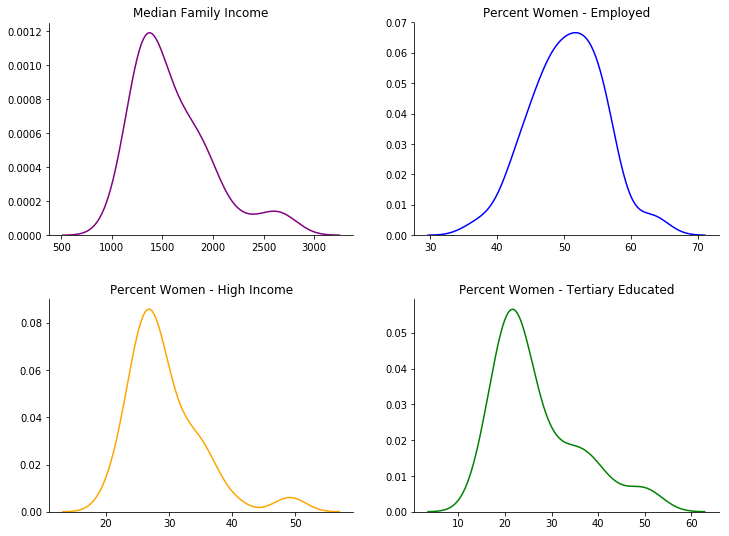

In [59]:
fig_dist = plt.figure(figsize = (12, 9))

ax1 = fig_dist.add_subplot(221, title = "Median Family Income")
ax2 = fig_dist.add_subplot(222, title = "Percent Women - Employed")
ax3 = fig_dist.add_subplot(223, title = "Percent Women - High Income")
ax4 = fig_dist.add_subplot(224, title = "Percent Women - Tertiary Educated")

axes = [ax1, ax2, ax3, ax4]
feature_list = ['median_fam_inc_weekly', 'pcent_women_employed', 'pcent_women_high_income', 'pcent_women_tertiary_educ']
colours = ['purple', 'blue', 'orange', 'green']

plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
sns.despine(fig = fig_dist)

for i in range(len(feature_list)):
    sns.distplot(df_gcp[feature_list[i]], ax = axes[i], hist = False, axlabel = False, color = colours[i])

fig_dist.show()

Observation: The percent women employed is symmetrical, but the other features are not. Hence it is appropriate to use the quartiles to assess spread, as these are less sensitive to skew.

This is confirmed by computing the skew for each feature. The skewness around 0 indicates a normal distribution. A skewness away from 0 indicates skew.

In [60]:
print('SKEWNESS')
print('Median family income\t\t\t', round(skew(df_gcp['median_fam_inc_weekly']), 3))
print('Percent women - employed\t\t', round(skew(df_gcp['pcent_women_employed']), 3))
print('Percent women - high income\t\t', round(skew(df_gcp['pcent_women_high_income']), 3))
print('Percent women - tertiary educated\t', round(skew(df_gcp['pcent_women_tertiary_educ']), 3))

SKEWNESS
Median family income			 1.188
Percent women - employed		 -0.035
Percent women - high income		 1.483
Percent women - tertiary educated	 1.116


This confirms that all features, bar one, are skewed. Therefore the assumption of normality is invalid.

### Visualise correlations between features and number of studios per 10000 women

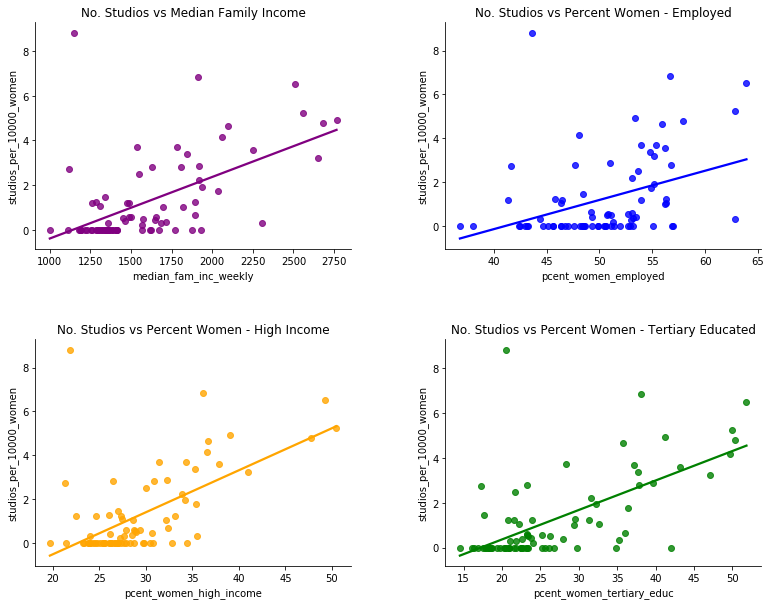

In [61]:
fig_scatter = plt.figure(figsize = (13, 10))

ax1 = fig_scatter.add_subplot(221, title = "No. Studios vs Median Family Income")
ax2 = fig_scatter.add_subplot(222, title = "No. Studios vs Percent Women - Employed")
ax3 = fig_scatter.add_subplot(223, title = "No. Studios vs Percent Women - High Income")
ax4 = fig_scatter.add_subplot(224, title = "No. Studios vs Percent Women - Tertiary Educated")

axes = [ax1, ax2, ax3, ax4]

plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
sns.despine(fig = fig_scatter)

for i in range(len(feature_list)):
    sns.regplot(data = df_gcp, x = feature_list[i], y = 'studios_per_10000_women',
                ax = axes[i], ci = None, color = colours[i])

fig_scatter.show()

Observations:

Correlation visible in all four features, but extent is not clear. Need mathematical confirmation.

### Confirm correlations between features and number of studios in an LGA

In [62]:
feature_names = ['median_fam_inc_weekly', 'pcent_women_employed', 'pcent_women_high_income', 'pcent_women_tertiary_educ']

df_gcp[feature_names].corrwith(df_gcp['studios_per_10000_women']).round(3)

median_fam_inc_weekly        0.566
pcent_women_employed         0.377
pcent_women_high_income      0.601
pcent_women_tertiary_educ    0.634
dtype: float64

Observations:

Moderate correlation between the following features and num studios per 10000 women:

median family income
percent women high income
percent women tertiary educated
Weak correlation between the following feature and num studios per 10000 women:

percent women employed
So, the percentage of women employed may not be a determining factor in the number of studios present in a LGA. This may be because many women in Australia, who are in dual-income households, do not do paid work; they are in an arrangement where a male partner is the breadwinner and the female is responsible for childrearing. If the male partner's income is high enough, then the woman would be able to afford participation in yoga/pilates, thereby invalidating the assumption that a women must be earning her own money in order to participate in these activities.

## PART 3: MODELLING

First extract features from cleaned data

In [64]:
feature_list = ['median_fam_inc_weekly', 'pcent_women_employed', 
                'pcent_women_high_income', 'pcent_women_tertiary_educ', 'studios_per_10000_women']

X = df_gcp[feature_list]

X.head()

,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
0,1322,50.4,26.671987,25.618516,0.000000
1,1263,48.4,27.032483,20.866214,0.000000
2,1489,50.8,28.746143,25.217243,0.567956
3,2033,54.9,35.404827,36.423281,1.755954
4,1192,42.4,23.409413,22.416036,0.000000


Check data types before normalisation

In [65]:
X.dtypes

median_fam_inc_weekly          int64
pcent_women_employed         float64
pcent_women_high_income      float64
pcent_women_tertiary_educ    float64
studios_per_10000_women      float64
dtype: object

Convert median_fam_inc_weekly to float64 to avoid a dataconversionwarning when normalising

In [66]:
X['median_fam_inc_weekly'] = X['median_fam_inc_weekly'].astype('float')

print(X.dtypes)
X.head()

median_fam_inc_weekly        float64
pcent_women_employed         float64
pcent_women_high_income      float64
pcent_women_tertiary_educ    float64
studios_per_10000_women      float64
dtype: object


,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
0,1322.0,50.4,26.671987,25.618516,0.000000
1,1263.0,48.4,27.032483,20.866214,0.000000
2,1489.0,50.8,28.746143,25.217243,0.567956
3,2033.0,54.9,35.404827,36.423281,1.755954
4,1192.0,42.4,23.409413,22.416036,0.000000


Normalise feature set

In [67]:
X_norm = StandardScaler().fit_transform(X)

# look at the first five rows to confirm that normalisation occurred as expected
X_norm[0:5]

array([[-0.70971672, -0.01207879, -0.45410607, -0.13236526, -0.66736528],
       [-0.86164056, -0.3862845 , -0.39302059, -0.65361829, -0.66736528],
       [-0.27969501,  0.06276235, -0.1026435 , -0.17637855, -0.36639251],
       [ 1.12109427,  0.82988404,  1.0256608 ,  1.05274821,  0.26315484],
       [-1.04446416, -1.50890161, -1.0069444 , -0.4836271 , -0.66736528]])

### Create and fit model
Start with three clusters

In [68]:
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 15, random_state = 1)

k_means.fit(X_norm)

k_means.labels_

array([0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 2,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 2,
       1, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0], dtype=int32)

Add cluster labels to dataset

In [69]:
df_gcp['clust_num'] = k_means.labels_

df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women,clust_num
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,0.000000,0
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,0.000000,0
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,0.567956,0
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,1.755954,1
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,0.000000,0


### Examine commonalities within clusters
Find mean of each feature in each cluster number. This gives an indication of what each cluster has in common.

In [70]:
feature_list.append('clust_num')
df_gcp[feature_list].groupby('clust_num').mean()

,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
clust_num,,,,,
0,1332.522727,46.988636,25.783066,21.537916,0.448608
1,1772.884615,54.196154,31.135261,29.405436,1.380342
2,2387.333333,56.677778,41.647538,45.220998,4.873561


Observations:

Cluster 0: low family income; reasonably high employment of women; very low percentage of high income women; very low percentage of tertiary educated women; very few studios per 10000 women

Cluster 1: medium family income; high employment of women; low percentage of high income women; low percentage of tertiary educated women; few studios per 10000 women

Cluster 2: high family income; high employment of women; high percentage of high income women; high percentage of tertiary educated women; many studios per 10000 women

Cluster 2 is already well-serviced by studios. Wealthy demographics.

Cluster 0 is low-income, low-education demographics. Likely to be little/no market need.

Cluster 1 has mixed demographics. Medium family income, but unfavourable individual income/education levels. Market need is unclear for these LGAs; cannot recommend new studios in these LGAs with confidence.

### Re-fit model with four clusters

In [71]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 15, random_state = 1)

k_means.fit(X_norm)

k_means.labels_

array([0, 3, 0, 2, 3, 0, 1, 3, 1, 3, 3, 3, 0, 0, 3, 0, 3, 2, 3, 0, 3, 2,
       3, 0, 0, 3, 0, 0, 3, 3, 2, 0, 3, 2, 2, 2, 3, 3, 0, 2, 0, 2, 2, 2,
       0, 3, 0, 3, 2, 2, 0, 2, 0, 3, 0, 3, 2, 3, 1, 3, 3, 3, 0, 1, 3, 2,
       3, 0, 0, 0, 3, 0, 2, 0, 0, 0, 1, 0, 3], dtype=int32)

In [72]:
df_gcp['clust_num'] = k_means.labels_

df_gcp.head()

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women,clust_num
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,0.000000,0
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,0.000000,3
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,0.567956,0
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,1.755954,2
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,0.000000,3


### Re-examine commonalities within clusters

In [74]:
df_gcp[feature_list].groupby('clust_num').mean()

,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women
clust_num,,,,,
0,1534.857143,52.271429,28.227112,23.566382,0.429530
1,2633.000000,58.640000,45.503261,48.075504,4.928053
2,1935.176471,54.364706,34.193986,36.134710,2.634130
3,1281.827586,45.024138,24.814702,20.850771,0.622152


Observations:

Cluster 0: low family income, high % women employed, very low % high income women, very low % tertiary educ, very low studios per 10000

Cluster 1: high family income, high % women employed, high % high income women, high % tertiary educ, high studios per 10000

Cluster 2: moderately high family income, high % women employed, low-med % high income women, low-med % tertiary educ, moderate studios per 10000

Cluster 3: very low family income, moderate % women employed, very low % high income women, very low % tertiary educ, very low studios per 10000

This tells us that the LGAs in Cluster 1 are well-serviced by studios. Wealthy, highly educated demographics.

The LGAs in Cluster 2 have similar demographics (though not quite as wealthy), and have fewer studios. These LGAs may be underserviced and may have a market need for more studios.

The LGAs in Clusters 0 and 3 have low-income and low-education demographics. Likely to be little/no market need for more studios in these areas.

CONCLUSION: Choose the LGAs in Cluster 2.

### Visualise clusters on map of Victoria
First remove (Vic.) and dashes from LGA names in df_gcp. This will ensure that the lga names perfectly match those in the geojson file

In [76]:
pattern = re.compile('\(Vic.\)')
df_gcp['lga_name'].replace(pattern, '', inplace = True)

pattern = re.compile('-')
df_gcp['lga_name'].replace(pattern, ' ', inplace = True)

df_gcp['lga_name'] = df_gcp['lga_name'].apply(lambda x: x.strip())

df_gcp.head(5)

,lga_code,lga_name,total_women,median_fam_inc_weekly,pcent_women_employed,pcent_women_high_income,pcent_women_tertiary_educ,studios_per_10000_women,clust_num
0,20110,Alpine,6265,1322,50.4,26.671987,25.618516,0.000000,0
1,20260,Ararat,5449,1263,48.4,27.032483,20.866214,0.000000,3
2,20570,Ballarat,52821,1489,50.8,28.746143,25.217243,0.567956,0
3,20660,Banyule,62644,2033,54.9,35.404827,36.423281,1.755954,2
4,20740,Bass Coast,16912,1192,42.4,23.409413,22.416036,0.000000,3


Create separate df for capitalised lga names that will match geojson

In [77]:
df_plot = df_gcp['lga_name'].apply(lambda x: x.upper())
df_plot = pd.concat([df_plot, df_gcp['clust_num']], axis = 1)

df_plot.head()

,lga_name,clust_num
0,ALPINE,0
1,ARARAT,3
2,BALLARAT,0
3,BANYULE,2
4,BASS COAST,3


Read in GeoJSON file

In [79]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
json_data = client_043a2ac56bbf4fe69b130a5ba4e5b0a2.get_object(Bucket='course9capstone-donotdelete-pr-qqz1u6olup7n1i', Key='VIC_LOCALITY_POLYGON_shp.geojson')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(json_data, "__iter__"): json_data.__iter__ = types.MethodType( __iter__, json_data ) 